# SHAP

![SHAP image sample](https://github.com/sony/nnabla-examples/raw/master/responsible_ai/shap/images/sample.png)
This example interactively demonstrates SHAP using nnabla's pre-trained model.

[Scott M Lundberg and Su-In Lee. A Unified Approach to Interpreting Model Predictions. In Advances in Neural Information Processing Systems 30, pages 4768–4. 2017.](https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html)

# Preparation
Let's start by installing nnabla and accessing [nnabla-examples repository](https://github.com/sony/nnabla-examples). If you're running on Colab, make sure that your Runtime setting is set as GPU, which can be set up from the top menu (Runtime → change runtime type), and make sure to click **Connect** on the top right-hand side of the screen before you start.

In [ ]:
# May show warnings for newly imported packages if run in Colab default python environment.
# Please click the `RESTART RUNTIME` to run the following script correctly.
# The error message of conflicts is acceptable.
!pip install nnabla-ext-cuda116
!git clone https://github.com/sony/nnabla-examples.git

In [ ]:
%cd nnabla-examples/responsible_ai/shap

Import dependencies.

In [ ]:
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import nnabla as nn
from nnabla.utils.image_utils import imread
from nnabla.models.imagenet import VGG16
from utils import shap_computation

## Image Preparation 
Prepare image to apply to SHAP.

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/commons/4/4e/A_crab_spider_on_a_flower_preying_upon_a_euglossine_bee%2C_while_a_butterfly_looks_for_nectar.jpg'
target_img_path = 'input_flower_moth_spider.jpg'
if not os.path.isfile(target_img_path):
    tgt = urllib.request.urlopen(url).read()
    with open(target_img_path, mode='wb') as f:
        f.write(tgt)

Take a look at what the image looks like.  
We can see a flower in the middle on which a butterfly rests, which is called long-tailed skipper butterfly.

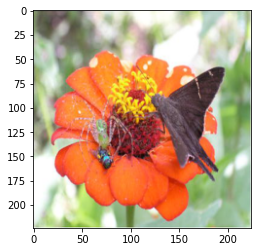

In [ ]:
img = imread(target_img_path, size=(224, 224), channel_first=True)
plt.imshow(img.transpose(1,2,0))
plt.show()

Then we prepare images to use when computing shap.

In [ ]:
file_path = "imagenet50"
if not os.path.isdir(file_path):
    !unzip "imagenet50.zip"
calc_images = []
for calc_img_path in os.listdir(file_path):
    calc_img = imread(file_path + "/" + calc_img_path, size=(224, 224), channel_first=True)
    calc_images.append(calc_img)
calc_images = np.array(calc_images)

## Network Definition
Loading the model is very simple.<br>
You can choose other models such as `VGG11`, `VGG13`, by specifying the model's name as an argument. Of course, you can choose other pretrained models as well. See the [Docs](https://nnabla.readthedocs.io/en/latest/python/api/models/imagenet.html).

**NOTE**: If you use the `VGG16` for the first time, nnabla will automatically download the weights from `https://nnabla.org` and it may take up to a few minutes.

In [ ]:
model = VGG16()

In [ ]:
batch_size = 1
x = nn.Variable((batch_size,) + model.input_shape)
# set training True since gradient of variable is necessary for SHAP
vgg = model(x, training=True, returns_net=True)
vgg_variables = vgg.variables

We now define the input, and extract the necessary outputs.  
pred: final output of the model

In [ ]:
target_label_indices = {
    'butterfly': 326,# lycaenid, lycaenid butterfly
    'flower': 985,# daisy
    'spider': 74,# garden spider
}

input_name = list(vgg.inputs.keys())[0]
vgg_variables[input_name].d = img
pred = vgg_variables["VGG16/Affine_3"]
selected = pred[:, target_label_indices['butterfly']]

Let's see how the model predicted the image.  
We can see the model classified the image as we expect.  
Labels regarding butterfly comes high, while flower is also recognized although it is14th ranked probability.

In [ ]:
selected.forward()

In [ ]:
predicted_labels = np.argsort(-pred.d[0])
for i, predicted_label in enumerate(predicted_labels[:15]):
    print(f'Top {i+1}, Label index: {predicted_label},  Label name: {model.category_names[predicted_label]}')

## SHAP Computation

Now we compute SHAP for butterfly and then for flower to save the images.

In [ ]:
shap_computation(
    model_graph=vgg,
    X=img,
    label=target_label_indices['butterfly'],
    output="img_butterfly.png",
    interim_layer_index=10,
    num_samples=50,
    dataset=calc_images,
    batch_size=25
)

In [ ]:
shap_computation(
    model_graph=vgg,
    X=img,
    label=target_label_indices['flower'],
    output="img_flower.png",
    interim_layer_index=10,
    num_samples=50,
    dataset=calc_images,
    batch_size=25
)

# Visualization

Finally, compare images in oneline to enable to see the differences clearly.

The **red** pixels represent places where SHAP judges **positive** influence to the prediction.<br>
On the other hand, **blue** pixel represents places where SHAP judges **negative** influence to the prediction.<br>

Image on the middle (pridiction for butterfly): The edge of the **butterfly** appears **red**, and the edge of the **flower** appears **blue**.<br>
Image on the right (pridiction for flower): The edge of the **butterfly** appears **blue**, and the edge of the **flower** appears **red**. 

In [ ]:
img_butterfly = imread("img_butterfly.png", size=(224, 224),channel_first=True)
img_flower = imread("img_flower.png", size=(224, 224), channel_first=True)

In [ ]:
images = {
    'original': img.transpose(1,2,0),
    'butterfly': img_butterfly.transpose(1,2,0),
    'flower': img_flower.transpose(1,2,0),
}

row = 1
col = len(images)
fig, axes = plt.subplots(row, col, figsize=(15,15))

for i, (k, v) in enumerate(images.items()):
    axes[i].axis("off")
    axes[i].imshow(v)
    axes[i].set_title(k)